# Halt Training at the Right Time with Early Stopping

A major challenge in training neural networks is how long to train them. Too little training
will mean that the model will underfit the train and the test sets. Too much training will
mean that the model will overfit the training dataset and have poor performance on the test
set. A compromise is to train on the training dataset but to stop training at the point when
performance on a validation dataset starts to degrade. This simple, effective, and widely used
approach to training neural networks is called early stopping. In this lab, you will discover
that stopping the training of a neural network early before it has overfit the training dataset
can reduce overfitting and improve the generalization of deep neural networks. After reading
this lab, you will know:

* The challenge of training a neural network long enough to learn the mapping, but not so long that it overfits the training data.
*  Model performance on a holdout validation dataset can be monitored during training and training stopped when generalization error starts to increase.
* The use of early stopping requires the selection of a performance measure to monitor, a trigger to stop training, and a selection of the model weights to use.

![image.png](attachment:image.png)

In [0]:
# Import libraries for data wrangling, preprocessing and visualization
import numpy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Importing libraries for building the neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


# Stop Training When Generalization Error Increases
Training neural networks is challenging. When training a large network, there will be a point
during training when the model will stop generalizing and start learning the statistical noise
in the training dataset. This overfitting of the training dataset will result in an increase in
generalization error, making the model less useful at making predictions on new data. The
challenge is to train the network long enough that it is capable of learning the mapping from
inputs to outputs, but not training the model so long that it overfits the training data.

However, all standard neural network architectures such as the fully connected
multi-layer perceptron are prone to overfitting: While the network seems to get
better and better, i.e., the error on the training set decreases, at some point during
training it actually begins to get worse again, i.e., the error on unseen examples
increases.

An alternative approach is to train the model once for a large number of training epochs.
During training, the model is evaluated on a holdout validation dataset after each epoch. If
the performance of the model on the validation dataset starts to degrade (e.g. loss begins to
increase or accuracy begins to decrease), then the training process is stopped.

The model at the time that training is stopped is then used and is known to have good
generalization performance. This procedure is called early stopping and is perhaps one of the
oldest and most widely used forms of neural network regularization.

If regularization methods like weight decay that update the loss function to encourage less
complex models are considered explicit regularization, then early stopping may be thought of as
a type of implicit regularization, much like using a smaller network that has less capacity.

## When to Use Early Stopping
Early stopping is so easy to use, e.g. with the simplest trigger, that there is little reason to not
use it when training neural networks. Use of early stopping may be a staple of the modern
training of deep neural networks.

**Early stopping should be used almost universally.**

### Plot Learning Curves to Select a Trigger
Before using early stopping, it may be interesting to fit an under constrained model and monitor
the performance of the model on a train and validation dataset. Plotting the performance of the
model in real-time or at the end of a long run will show how noisy the training process is with
your specific model and dataset. This may help in the choice of a trigger for early stopping.

#### Monitor an Important Metric for your domain (not for the machine learning algo.)
Loss is an easy metric to monitor during training and to trigger early stopping. The problem is
that loss does not always capture what is most important about the model to you and your
project.

Sometimes, the loss function we actually care about (say classification error) is not
one that can be optimized efficiently. n such situations, one typically optimizes
a surrogate loss function instead, which acts as a proxy but has advantages.

It may be better to choose a performance metric to monitor that best defines the performance
of the model in terms of the way you intend to use it. This may be the metric that you intend
to use to report the performance of the model.

## Early Stopping Keras API

A callback is a snippet of code that can be executed at a specific point during training, such as
before or after training, an epoch or a batch. They provide a way to execute code and interact
with the training model process automatically. Callbacks can be provided to the fit() function
via the callbacks argument. First, callback must be instantiated.

The following is an example of creating a callback function:

```ptyhon
cb = Callback(...)
```
 
 
Then, one or more callbacks that you intend to use must be added to a Python list as follows:

```python
cb_list = [cb, ...]
```

Finally, the list of callbacks is provided to the callback argument when fitting the neural network model. E.g.,

```python
nn = model.fit(..., callbacks=cb_list)
```

### Evaluating a Validation Dataset in Keras
Early stopping requires that a validation dataset is evaluated during training. This can be
achieved by specifying the validation dataset to the `fit()` function when training your model.
There are two ways of doing this. The first involves you manually splitting your training data
into a train and validation dataset and specifying the validation dataset to the `fit()` function
via the validation data argument. For example:

```python
model.fit(train_X, train_y, validation_data=(val_x, val_y))
```

Alternately, the `fit()` function can automatically split your training dataset into train and
validation sets based on a percentage split specified via the validation split argument. The
validation split is a value between 0 and 1 and defines the percentage amount of the training
dataset to use for the validation dataset. For example:

```python
model.fit(train_X, train_y, validation_split=0.3)
```

In both cases, the model is not trained on the validation dataset. Instead, the model is
evaluated on the validation dataset at the end of each training epoch.

### Monitoring Model Performance
The loss function chosen to be optimized for your model is calculated at the end of each epoch.
To callbacks, this is made available via the name loss. If a validation dataset is specified to
the fit() function via the validation data or validation split arguments, then the loss
on the validation dataset will be made available via the name val loss. Additional metrics
can be monitored during the training of the model. They can be specified when compiling the
model via the metrics argument to the compile function. This argument takes a Python list of
known metric functions, such as mse for mean squared error and acc for accuracy. 

For example:
```python
model.compile(..., metrics=['acc'])
```

If additional metrics are monitored during training, they are also available to the callbacks
via the same name, such as acc for accuracy on the training dataset and val acc for the
accuracy on the validation dataset. Or, mse for mean squared error on the training dataset and
val mse on the validation dataset.

### Early Stopping Callback
Keras supports the early stopping of training via a callback called `EarlyStopping`. This callback
allows you to specify the performance measure to monitor, the trigger, and once triggered, it
will stop the training process. The `EarlyStopping` callback is configured when instantiated via
arguments. The monitor allows you to specify the performance measure to monitor in order to
end training. Recall from the previous section that the calculation of measures on the validation
dataset will have the val prefix, such as val loss for the loss on the validation dataset.

```python
es = EarlyStopping(monitor='val_loss')
```

By default, mode is set to auto and knows that you want to minimize loss or maximize
accuracy. That is all that is needed for the simplest form of early stopping. Training will stop
when the chosen performance measure stops improving. To discover the training epoch on which
training was stopped, the verbose argument can be set to 1. Once stopped, the callback will
print the epoch number.

```python
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
```
#### Patience mode
Often, the first sign of no further improvement may not be the best time to stop training.
This is because the model may coast into a plateau of no improvement or even get slightly worse
before getting much better. We can account for this by adding a delay to the trigger in terms
of the number of epochs on which we would like to see no improvement. This can be done by
setting the patience argument.

```python
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
```

The exact amount of patience will vary between models and problems. Reviewing plots
of your performance measure can be very useful to get an idea of how noisy the optimization
process for your model on your data may be. By default, any change in the performance measure,
no matter how fractional, will be considered an improvement. You may want to consider an
improvement that is a specific increment, such as 1 unit for mean squared error or 1% for
accuracy. This can be specified via the min delta argument.

```python
es = EarlyStopping(monitor='val_acc', mode='max', min_delta=1)
```

Finally, it may be desirable to only stop training if performance stays above or below a given
threshold or baseline. For example, if you have familiarity with the training of the model (e.g.
learning curves) and know that once a validation loss of a given value is achieved that there
is no point in continuing training. This can be specified by setting the baseline argument.
This might be more useful when fine tuning a model, after the initial wild 
fluctuations in the performance measure seen in the early stages of training a new model are past.

```python
es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4)
```


## Model Checkpointing
The EarlyStopping callback will stop training once triggered, but the model at the end of
training may not be the model with best performance on the validation dataset. An additional
callback is required that will save the best model observed during training for later use. This is
the ModelCheckpoint callback. The `ModelCheckpoint` callback is 
exible in the way it can be
used, but in this case we will use it only to save the best model observed during training as
defined by a chosen performance measure on the validation dataset. Saving and loading models
requires that HDF5 support has been installed on your workstation. For example, using the
pip Python installer, this can be achieved as follows:
sudo pip install h5py
You can learn more from the h5py Installation documentation1. The callback will save the
model to file, which requires that a path and filename be specified via the first argument.

```python
mc = ModelCheckpoint('best_model.h5')
```

The preferred loss function to be monitored can be specified via the monitor argument, in
the same way as the `EarlyStopping` callback. For example, loss on the validation dataset (the
default).

```python
mc = ModelCheckpoint('best_model.h5', monitor='val_loss')
```

Also, as with the `EarlyStopping` callback, we must specify the mode as either minimizing
or maximizing the performance measure. Again, the default is auto, which is aware of the
standard performance measures.

```python
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min')
```
The above is an example of model checkpoint that monitors a minimized validation loss.

Finally, we are interested in only the very best model observed during training, rather than
the best compared to the previous epoch, which might not be the best overall if training is noisy.
This can be achieved by setting the save best only argument to True.

```python
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
```
This is an example of model checkpoint that only saves the best.

That is all that is needed to ensure the model with the best performance is saved when
using early stopping, or in general. It may be interesting to know the value of the performance
measure and at what epoch the model was saved. This can be printed by the callback by setting
the `verbose argument to 1`.

```python
# Example of model checkpoint with verbose output
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
```

The saved model can then be loaded and evaluated any time by calling the `load model()`
function.


```python
# load a saved (checkpoint) model
from keras.models import load_model
saved_model = load_model('best_model.h5')
```

Now that we know how to use the early stopping and model checkpoint APIs, let's look at a
worked example.

# Model the 2 halfmoon classification problem

## Gererate a 2-class dataset

Binary Classification Problem
We will use a standard binary classication problem that denes two semi-circles of observations,
one semi-circle for each class. Each observation has two input variables with the same scale and
a class output value of either 0 or 1. This dataset is called the moons dataset because of the
shape of the observations in each class when plotted. We can use the make moons() function to
generate observations from this problem. We will add noise to the data and seed the random
number generator so that the same samples are generated each time the code is run.

```python
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
```

We can plot the dataset where the two variables are taken as x and y coordinates on a graph
and the class value is taken as the color of the observation. The complete example of generating
the dataset and plotting it is listed below.

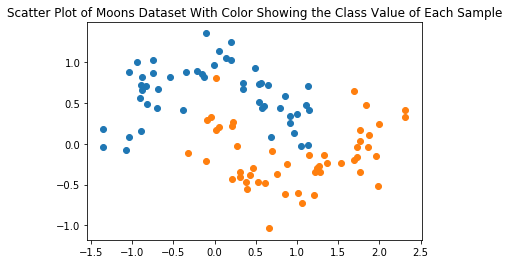

In [0]:
# scatter plot of moons dataset
from sklearn.datasets import make_moons
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
# scatter plot for each class value
for class_value in range(2):
    # select indices of points with the class label
    row_ix = where(y == class_value)
    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show plot
pyplot.title("Scatter Plot of Moons Dataset With Color Showing the Class Value of Each Sample")
pyplot.show()

This is a good test problem because the classes cannot be separated by a straight line, e.g.
are not linearly separable, requiring a nonlinear method such as a neural network to address. We
have only generated 100 samples, which is small for a neural network, providing the opportunity
to overfit the training dataset and have higher error on the test dataset: a good case for using
regularization. Further, the samples have noise, giving the model an opportunity to learn aspects
of the samples that don't generalize.

## mlp overfit the training data with simple early stopping

Next, we can dedne the model. The hidden layer uses 500 nodes and the rectified linear
activation function. A sigmoid activation function is used in the output layer in order to predict
class values of 0 or 1. The model is optimized using the binary cross-entropy loss function,
suitable for binary classification problems and the efficient `Adam` version of gradient descent.

```python
# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

The dedefned model is then fit on the training data for 4,000 epochs and the default batch
size of 32. We will also use the test dataset as a validation dataset. This is just a simplification
for this example. In practice, you would split the training set into train and validation and also
hold back a test set for final model evaluation.

```python
# fit model: Example of fitting the MLP model.
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0)
```

We can evaluate the performance of the model on the heldout test dataset and report the result.

```python
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, val_acc = model.evaluate(validationX, validationy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Val: %.3f Test: %.3f' % (train_acc, val_acc, test_acc))
```

Finally, we will plot the loss and accuracy of the model on both the train and test set each
epoch. If the model does indeed overfit the training dataset, we would expect the line plot of
loss (and accuracy) on the training set to continue to increase and the test set to rise and then
fall again as the model learns statistical noise in the training dataset.

Running the example reports the model performance on the train and test datasets. We can
see that the model has better performance on the training dataset than the test dataset, one
possible sign of overfitting.
Note: Your specific results may vary given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

Epoch 00029: early stopping
Train: 0.900, Val: 0.767 Test: 0.633


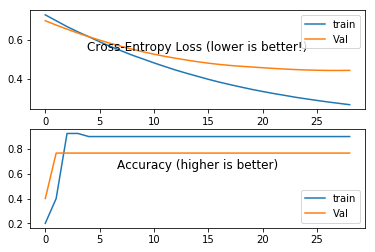

In [0]:
# mlp overfit on the moons dataset with patient early stopping
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
numpy.random.seed(42)


# split into train, validaton and test
# Note the blind is not used during training at all
# Jimi keeps it under lock and key!
n_train = 40
n_validation = 30

trainX, validationX, testX = X[:n_train, :], X[n_train:n_train+n_validation, :], X[n_train+n_validation:, :]
trainy, validationy, testy = y[:n_train], y[n_train:n_train+n_validation], y[n_train+n_validation:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# fit model
history = model.fit(trainX, trainy, validation_data=(validationX, validationy), 
                    epochs=4000, verbose=0, callbacks=[es])

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, val_acc = model.evaluate(validationX, validationy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Val: %.3f Test: %.3f' % (train_acc, val_acc, test_acc))


# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss (lower is better!)', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='Val')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy (higher is better)', pad=-40)
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='Val')
pyplot.legend()
pyplot.show()



The above figure is created showing line plots of the model loss and accuracy on the train and test
sets. We can see that expected shape of an overfit model where test accuracy increases to a
point and then begins to decrease again. We can also see that the callback stopped training at epoch 23. This is too early as we
would expect an early stop to be around epoch 800 (see next section). This is also highlighted by the classification
accuracy on both the train and test sets, which is worse than no early stopping.

Reviewing the line plot of train and test loss, we can indeed see that training was stopped
at the point when validation loss began to plateau for the rst time.

## mlp overfit the training data with patient early stopping

We can improve the trigger for early stopping by waiting a while before stopping. This can
be achieved by setting the patience argument. In this case, we will wait 200 epochs before
training is stopped. Specifically, this means that we will allow training to continue for up to an
additional 200 epochs after the point that validation loss started to degrade, giving the training
process an opportunity to get across 
flat spots or find some additional improvement.

W0724 22:52:35.797903 140522009622400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 22:52:35.863314 140522009622400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 22:52:35.873289 140522009622400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 22:52:35.913650 140522009622400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 22:52:35.941121 140522009622400 deprecation_wrappe

Epoch 00970: early stopping
Train: 1.000, Val: 0.900 Test: 0.933


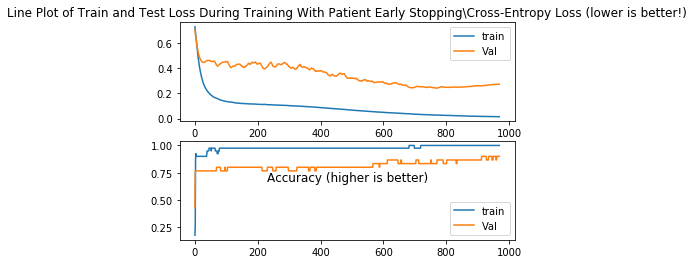

In [0]:
# mlp overfit on the moons dataset with patient early stopping
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
import numpy as numpy
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
numpy.random.seed(42)


# split into train, validaton and test
# Note the blind is not used during training at all
# Jim keeps it under lock and key!
n_train = 40
n_validation = 30

trainX, validationX, testX = X[:n_train, :], X[n_train:n_train+n_validation, :], X[n_train+n_validation:, :]
trainy, validationy, testy = y[:n_train], y[n_train:n_train+n_validation], y[n_train+n_validation:]


# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# fit model
history = model.fit(trainX, trainy, validation_data=(validationX, validationy), 
                    epochs=4000, verbose=0, callbacks=[es])

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, val_acc = model.evaluate(validationX, validationy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Val: %.3f Test: %.3f' % (train_acc, val_acc, test_acc))


# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Line Plot of Train and Test Loss During Training With Patient Early Stopping\Cross-Entropy Loss (lower is better!)')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='Val')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy (higher is better)', pad=-40)
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='Val')
pyplot.legend()
pyplot.show()


The above figure is created showing line plots of the model loss and accuracy on the train and validation
sets. We can see that expected shape of an overfit model where validation accuracy increases to a
point and then begins to decrease again. Reviewing the figure, we can also see 
flat spots in
the ups and downs in the validation loss. Any early stopping will have to account for these
behaviors. We would also expect that a good time to stop training might be around epoch 700.

Running the example, we can see that training was stopped much later, in this case just
before epoch 1,000 (of the budgeted 4,000 epochs).
Note: Your specific results may vary given the stochastic nature of the learning algorithm.
Consider running the example a few times and compare the average performance.
We can also see that the performance on the validation dataset is better than not using any early
stopping.

Reviewing the line plot of loss during training, we can see that the patience allowed the
training to progress past some small 
flat and bad spots.

We can also see that validation loss started to increase again in the last approximately 200 epochs.
This means that although the performance of the model has improved, we may not have the
best performing or most stable model at the end of training. We can address this by using
a `ModelChecckpoint` callback. In this case, we are interested in saving the model with the
best accuracy on the validation dataset. We could also seek the model with the best loss on the validation
dataset, but this may or may not correspond to the model with the best accuracy.
This highlights an important concept in model selection. The notion of the best model during
training may con
ict when evaluated using different performance measures. Try to choose
models based on the metric by which they will be evaluated and presented in the domain. In a
balanced binary classification problem, this will most likely be classification accuracy. Therefore,
we will use accuracy on the validation in the ModelCheckpoint callback to save the best model
observed during training.
```python
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1,
save_best_only=True)
```

## mlp overfit the with patient early stopping and model checkpointing

During training, the entire model will be saved to the le best model.h5 only when accuracy
on the validation dataset improves overall across the entire training process. A verbose output
will also inform us as to the epoch and accuracy value each time the model is saved to the same
file (e.g. overwritten). This new additional callback can be added to the list of callbacks when
calling the fit() function.

```python
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0,
callbacks=[es, mc])
```

Following training, we want to load the saved model from file and evaluate its
performance on the heldout test dataset.

```python
# load the saved model
saved_model = load_model('best_model.h5')
print("best model is saved to best_model.h5")
# evaluate the model
_, train_acc = saved_model.evaluate(trainX, trainy, verbose=0)
_, val_acc = saved_model.evaluate(validationX, validationy, verbose=0)
_, test_acc = saved_model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Val: %.3f Test: %.3f' % (train_acc, val_acc, test_acc))
```

Epoch 01042: early stopping
best model is saved to best_model.h5
Train: 1.000, Val: 0.933 Test: 0.933


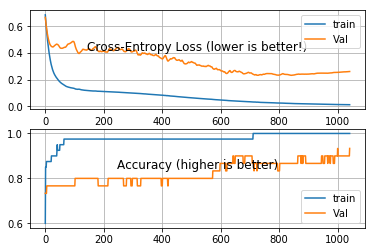

In [0]:
# mlp overfit on the moons dataset with patient early stopping and model checkpointing
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as pyplot
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train, validaton and test
# Note the blind is not used during training at all
# Jimi keeps it under lock and key!
n_train = 40
n_validation = 30

trainX, validationX, testX = X[:n_train, :], X[n_train:n_train+n_validation, :], X[n_train+n_validation:, :]
trainy, validationy, testy = y[:n_train], y[n_train:n_train+n_validation], y[n_train+n_validation:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', 
                     verbose=0, save_best_only=True)
# fit model
history = model.fit(trainX, trainy, validation_data=(validationX, validationy), epochs=4000, 
                    verbose=0,  #change to 1 to a verbose reporting of learning
                    callbacks=[es, mc])

# load the saved model
saved_model = load_model('best_model.h5')
print("best model is saved to best_model.h5")
# evaluate the model
_, train_acc = saved_model.evaluate(trainX, trainy, verbose=0)
_, val_acc = saved_model.evaluate(validationX, validationy, verbose=0)
_, test_acc = saved_model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Val: %.3f Test: %.3f' % (train_acc, val_acc, test_acc))


# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss (lower is better!)', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='Val')
pyplot.grid(True)
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy (higher is better)', pad=-40)
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='Val')
pyplot.grid(True)
pyplot.legend()
pyplot.show()


## Patience explained with an example finally! 

Running the example, we can see the verbose output from the ModelCheckpoint callback
for both when a new best model is saved and from when no improvement was observed. 

For the purposes of this discussion let's use the following output log as example output fitting an MLP with patient early stopping with model checkpointing on the two moons problem.


```
Epoch 00878: val_acc did not improve from 0.92857
Epoch 00879: val_acc improved from 0.92857 to 0.94286, saving model to best_model.h5
Epoch 00880: val_acc did not improve from 0.94286
...
Epoch 01042: val_acc did not improve from 0.94286
Epoch 01043: val_acc did not improve from 0.94286
Epoch 01044: val_acc did not improve from 0.94286
Epoch 01044: early stopping
Train: 1.000, Test: 0.943
```
 
 
 Based on the result above, we can
see that the best model was observed at epoch 879 during this run.
Note: Your specific results may vary given the stochastic nature of the learning algorithm.
Consider running the example a few times and compare the average performance.
Again, we can see that early stopping continued patiently until after epoch 1,000. Note that
epoch 880 + a patience of 200 is not epoch 1,044. Recall that early stopping is monitoring `loss` (the loss and not accuracy in this case)
on the validation dataset and that the model checkpoint is saving models based on accuracy.
As such, the patience of early stopping started at an epoch other than 880.


In this case, we don't see any further improvement in model accuracy on the test dataset.
Nevertheless, we have followed a good practice. Why not monitor validation accuracy for early
stopping? This is a good question. The main reason is that accuracy is a coarse measure
of model performance during training and that loss provides more nuance when using early
stopping with classification problems. The same measure may be used for early stopping and
model checkpointing in the case of regression, such as mean squared error.

# Task: Regression Example

* Create a new example of using early stopping to address overfitting
on the 10-variable regression problem given below.  Set the loss to  mean squared error and track the business KPI  MAE during training.

Adopt the  code below to complete this task.

Do early stopping using the loss function and checkpointing base upon the business KPI (MAE)

In [0]:
# mlp overfit on the moons dataset with patient early stopping and model checkpointing
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
# generate regression dataset
X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=1)



# split into train, validaton and test
# Note the blind is not used during training at all
# Jimi keeps it under lock and key!
n_train = 40
n_validation = 30

trainX, validationX, testX = X[:n_train, :], X[n_train:n_train+n_validation, :], X[n_train+n_validation:, :]
trainy, validationy, testy = y[:n_train], y[n_train:n_train+n_validation], y[n_train+n_validation:]

#  standardize the input training 
scaler = StandardScaler()
scaler = scaler.fit(trainX)
trainX = scaler.transform(...)
validationX = scaler.transform(...)
testX = scaler.transform(...)

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='????', optimizer='adam', metrics=['???'])


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_????', mode='max', 
                     verbose=0, save_best_only=True)
# fit model
history = model.fit(trainX, trainy, validation_data=(validationX, validationy), epochs=4000, 
                    verbose=0,  #change to 1 to a verbose reporting of learning
                    callbacks=[es, mc])

# load the saved model
saved_model = load_model('best_model.h5')
print("best model is saved to best_model.h5")
# evaluate the model
_, train_acc = saved_model.evaluate(trainX, trainy, verbose=0)
_, val_acc = saved_model.evaluate(validationX, validationy, verbose=0)
_, test_acc = saved_model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Val: %.3f Test: %.3f' % (train_, val_, test_))


# plot loss learning curves
pyplot.subplot(211)
pyplot.title('MSE Loss (lower is better!)', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='Val')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('XXXXX (higher is better)', pad=-40)
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='Val')
pyplot.legend()
pyplot.show()


TASK: apply early stopping model check pointing to the Boston dataset. Things to consider: MSE, MAE baseed, plateuu, based training or validation.....

Train, validation, test
Create a google sheetg scoreboard
